<a href="https://colab.research.google.com/github/AsadullahGalib007/QOSF-Screening-Task/blob/main/Task_4_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> TOC

>[Basics](#scrollTo=UWwgLDD6WDhs)

>[VQC](#scrollTo=WVNguMAJWNe0)

>>[Cost function](#scrollTo=tjq096MzWQ_g)

>>[Training and optimization](#scrollTo=V6qPRETHWWid)

>[Result and visualization](#scrollTo=UPRcLfrXWcw9)



# Basics

The idea is to create a vqc with random parameters($θ$). The vqc will use an optimization method(I used bfgs here) and find the circuit with optimized parameters that should represent the state vectors. I managed to achieve all the requirements, circuit `depth 39`, with the mentioned basis gates(I didn't have to use the `x` gate) using the given architecture.

In [1]:
# installation
!pip install qiskit[visualization] -q
!pip install qiskit_aer -q
!pip install qiskit_ibm_runtime -q
!pip install matplotlib -q
!pip install pylatexenc -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.3/343.3 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 9.7 MB/s eta 0:00:00


In [2]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import *
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties, CouplingMap, StagedPassManager, PassManager, AnalysisPass, TransformationPass
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q, generate_embed_passmanager
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import Aer, AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)
from qiskit.providers import BackendV2
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import state_fidelity

In [3]:
# config
n_layer = 4
basis_gates=['x', 'h', 'cx', 'rz']
entangling_pairs = [(0, 1), (0, 4), (1, 4), (2, 4), (2, 3), (4, 3)]

In [4]:
size = 5
# added 2 more states for testing
state_values = [5, 7, 22, 17, 27, 12]
# state_values = [22, 17, 27, 12]

state_vector = [0]*2**size

for s in state_values:
    print(np.binary_repr(s,size))
    state_vector[s] = 0.3

# this will normalize the matrix as required no matter what we put above
target_state_vector = state_vector/np.linalg.norm(state_vector)
np.asarray(target_state_vector)

print(target_state_vector)

00101
00111
10110
10001
11011
01100
[0.         0.         0.         0.         0.         0.40824829
 0.         0.40824829 0.         0.         0.         0.
 0.40824829 0.         0.         0.         0.         0.40824829
 0.         0.         0.         0.         0.40824829 0.
 0.         0.         0.         0.40824829 0.         0.
 0.         0.        ]


# VQC

In [5]:
# variational quantum circuit(vqc)
def create_variational_circuit(params):

    '''
    The RX, Ry, and Rz altogether can give me access to any point in Hilbert space.
    Increasing the parameters may give me more access to the Hilbert space, but that increases the circuit depth.
    As the requirement is to use the only mentioned gates, I can mimic the rx and ry
    using a combination of Hadamard and Rz gates.
    Here, the params/thetas used in Rz are to be optimized.
    '''

    qr = QuantumRegister(size, 'q')
    qc = QuantumCircuit(qr)

    param_index = 0
    for _ in range(n_layer):
        for i in range(size):

            # mimic rx(theta) with H-rz(theta)-H
            qc.h(qr[i])
            qc.rz(params[param_index], qr[i])
            qc.h(qr[i])
            param_index += 1

            # mimic ry(theta) with H-RZ(theta)-H
            qc.h(qr[i])
            qc.rz(params[param_index], qr[i])
            qc.h(qr[i])
            param_index += 1

            # apply rz(theta) directly
            qc.rz(params[param_index], qr[i])
            param_index += 1

        # considering the architecture
        for pair in entangling_pairs:
            qc.cx(qr[pair[0]], qr[pair[1]])

    # one extra layer
    for i in range(size):
            # mimic rx(theta) with H-rz(theta)-H
            qc.h(qr[i])
            qc.rz(params[param_index], qr[i])
            qc.h(qr[i])
            param_index += 1

            # mimic ry(theta) with H-RZ(theta)-H
            qc.h(qr[i])
            qc.rz(params[param_index], qr[i])
            qc.h(qr[i])
            param_index += 1

            # apply rz(theta) directly
            qc.rz(params[param_index], qr[i])
            param_index += 1

    return qc

## Cost function

In [6]:
# cost functiom
def cost_function(params):
    qc = create_variational_circuit(params)
    backend = Aer.get_backend('statevector_simulator')
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc)
    result = job.result()
    statevector = result.get_statevector()
    fidelity = state_fidelity(statevector, target_state_vector)
    return 1 - fidelity

# to check iteration vs fidelity
def callback(xk):
    global iteration_count
    iteration_count += 1
    if iteration_count % 10 == 0:
        fidelity = 1 - cost_function(xk)
        print(f"Iteration {iteration_count}: Fidelity = {fidelity:.6f}")

## Training and optimization

In [7]:
num_params = 5 * 3 * (n_layer+1)    # 5 qubits, 3 rotations per qubit (rx, ry, and rz), n_layers + 1 extra layer
n_trials = 5    # no. of random trials

best_result = None
best_fidelity = 0

for trials in range(n_trials):
    print(f"\nTrial {trials + 1}/{n_trials}")
    print('='*50)
    initial_params = np.random.rand(num_params) * 2 * np.pi

    global iteration_count
    iteration_count = 0

    result = minimize(cost_function,
                      initial_params,
                      method='bfgs',
                      options={'maxiter': 300,
                            #    'gtol': 1e-5
                               }, # maximum iterations, tolerance value
                      callback=callback)

    fidelity = 1 - result.fun
    print(f"Optimization result:")
    print(result)
    print(f"Final fidelity: {fidelity}\n")

    if fidelity > best_fidelity:
        best_result = result
        best_fidelity = fidelity

# use the best result
optimized_params = best_result.x
final_circuit = create_variational_circuit(optimized_params)


print("\nBest optimization result:")
print(f"Success: {best_result.success}")
print(f"Final cost: {best_result.fun}")
print(f"Final fidelity: {best_fidelity}")


Trial 1/5
Iteration 10: Fidelity = 0.696858
Iteration 20: Fidelity = 0.845400
Iteration 30: Fidelity = 0.902765
Iteration 40: Fidelity = 0.942037
Iteration 50: Fidelity = 0.957144
Iteration 60: Fidelity = 0.965312
Iteration 70: Fidelity = 0.968954
Iteration 80: Fidelity = 0.973570
Iteration 90: Fidelity = 0.975316
Iteration 100: Fidelity = 0.975605
Iteration 110: Fidelity = 0.975846
Iteration 120: Fidelity = 0.975910
Iteration 130: Fidelity = 0.976193
Iteration 140: Fidelity = 0.976204
Iteration 150: Fidelity = 0.976250
Iteration 160: Fidelity = 0.976253
Optimization result:
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.023747405352917972
        x: [ 3.441e+00  1.271e+00 ...  1.399e+00  5.111e-04]
      nit: 160
      jac: [ 1.989e-06  1.974e-06 ...  1.431e-06 -2.071e-06]
 hess_inv: [[ 4.389e+00  3.390e+00 ... -2.816e+00 -5.810e+00]
            [ 3.390e+00  4.390e+00 ... -2.816e+00 -5.812e+00]
            ...
            [-2.816e+00 -2.816

# Result and visualization

In [8]:
# verify states function
def verify_states(circuit, state_values):
    backend = Aer.get_backend('statevector_simulator')
    transpiled_circuit = transpile(circuit, backend, optimization_level=3, basis_gates = basis_gates)
    job = backend.run(transpiled_circuit)
    result = job.result()
    statevector = result.get_statevector()

    total_probability = 0
    for state in state_values:
        probability = abs(statevector[state])**2
        total_probability += probability
        binary_state = format(state, f'0{circuit.num_qubits}b')
        print(f"State |{binary_state}⟩: Probability = {probability:.4f}")

    print(f"Total probability of desired states: {total_probability:.4f}")
    return statevector
print("Verifying states:")
final_statevector = verify_states(final_circuit, state_values)

Verifying states:
State |00101⟩: Probability = 0.1667
State |00111⟩: Probability = 0.1667
State |10110⟩: Probability = 0.1667
State |10001⟩: Probability = 0.1667
State |11011⟩: Probability = 0.1667
State |01100⟩: Probability = 0.1667
Total probability of desired states: 1.0000


The task was to work on four state values. I added two more for testing and got the perfect score.

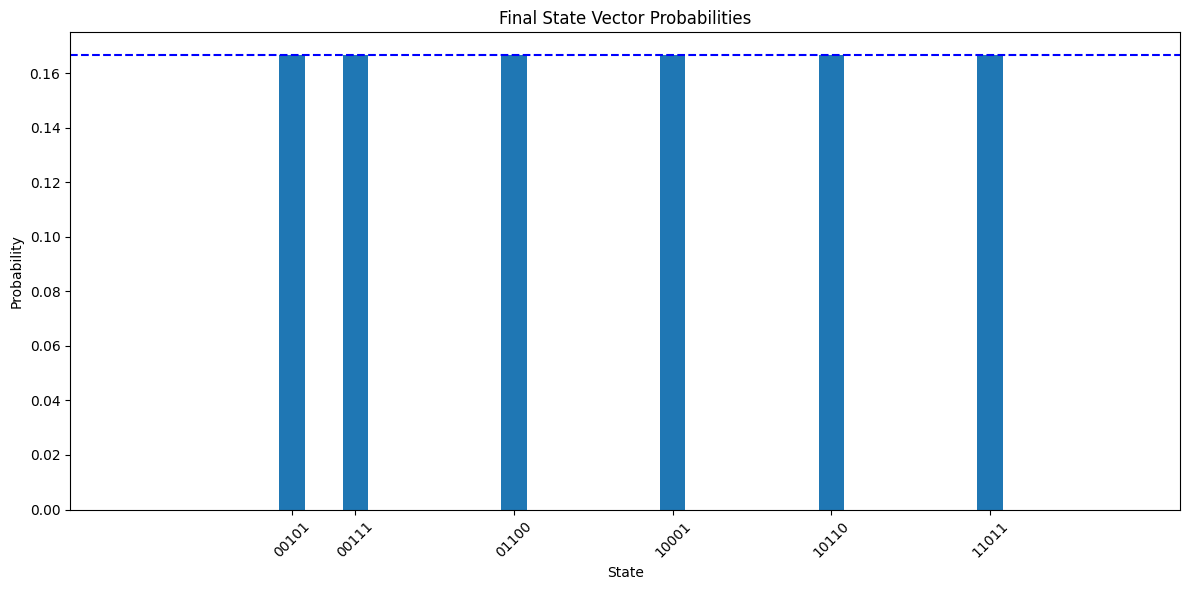

In [9]:
# Plot the final state vector
plt.figure(figsize=(12, 6))
plt.bar(range(2**size), np.abs(final_statevector)**2)
plt.xlabel('State')
plt.ylabel('Probability')
# Draw a horizontal line at y=equal probability
plt.axhline(y=1.0/(len(state_values)), color='b', linestyle='--')
plt.title('Final State Vector Probabilities')
plt.xticks(state_values, [format(s, f'0{size}b') for s in state_values], rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# depth of the final circuit and the transpiled circuit
print(f"Circuit depth: {final_circuit.depth()}")

backend = Aer.get_backend('qasm_simulator')
# considering the basis gates restriction
transpiled_circuit = transpile(final_circuit, backend, optimization_level=3, basis_gates = basis_gates)
print(f"Transpiled Circuit depth: {transpiled_circuit.depth()}")

Circuit depth: 56
Transpiled Circuit depth: 39


In [11]:
def get_qc_characteristics(qc):
    depth = qc.depth()
    num_qubits = qc.num_qubits
    ops = qc.count_ops()
    num_multi_qubit_ops = sum(1 for op in qc.data if len(op.qubits) > 1)
    return {"depth":depth, "num_qubits":num_qubits, "ops":ops, "num_multi_qubit_ops": num_multi_qubit_ops}

# print quantum circuit characteristics
def print_qc_characteristics(qc):
    characteristics = get_qc_characteristics(qc)
    print("Quantum circuit characteristics")
    print("  Depth:", characteristics['depth'])
    print("  Number of qubits:", characteristics['num_qubits'])
    print("  Operations:", dict(characteristics['ops']))
    print("  Number of multi-qubit Operations:", characteristics['num_multi_qubit_ops'])


# final circuit characteristics
print_qc_characteristics(final_circuit)

Quantum circuit characteristics
  Depth: 56
  Number of qubits: 5
  Operations: {'h': 100, 'rz': 75, 'cx': 24}
  Number of multi-qubit Operations: 24


Optimized Final Circuit:



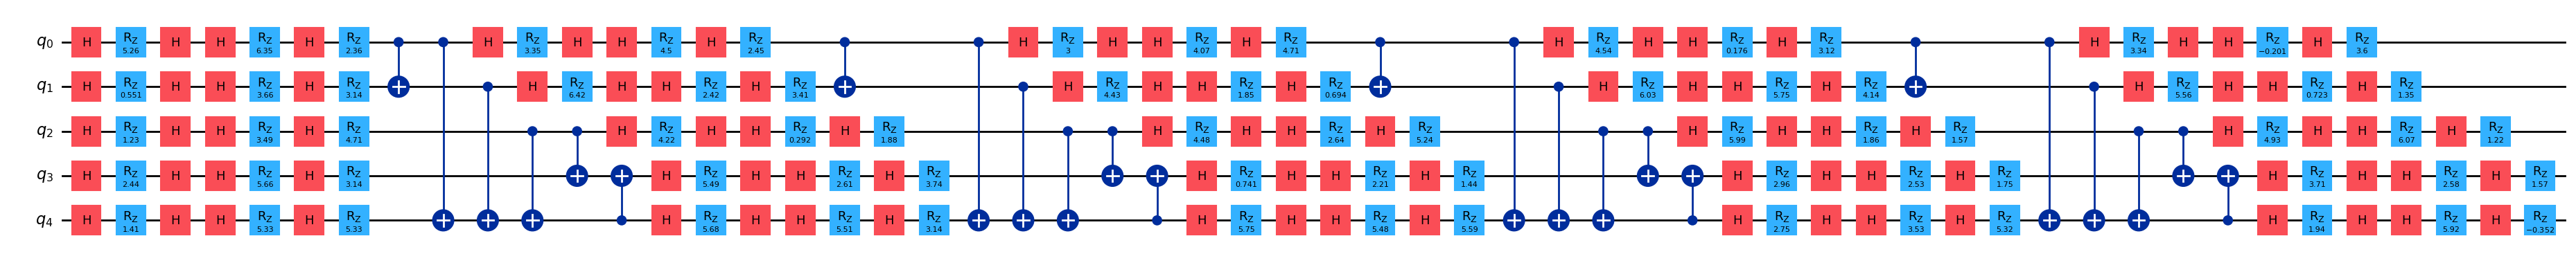

In [12]:
print("Optimized Final Circuit:\n")
final_circuit.draw("mpl", fold=-1)

Transpiled Final Circuit:



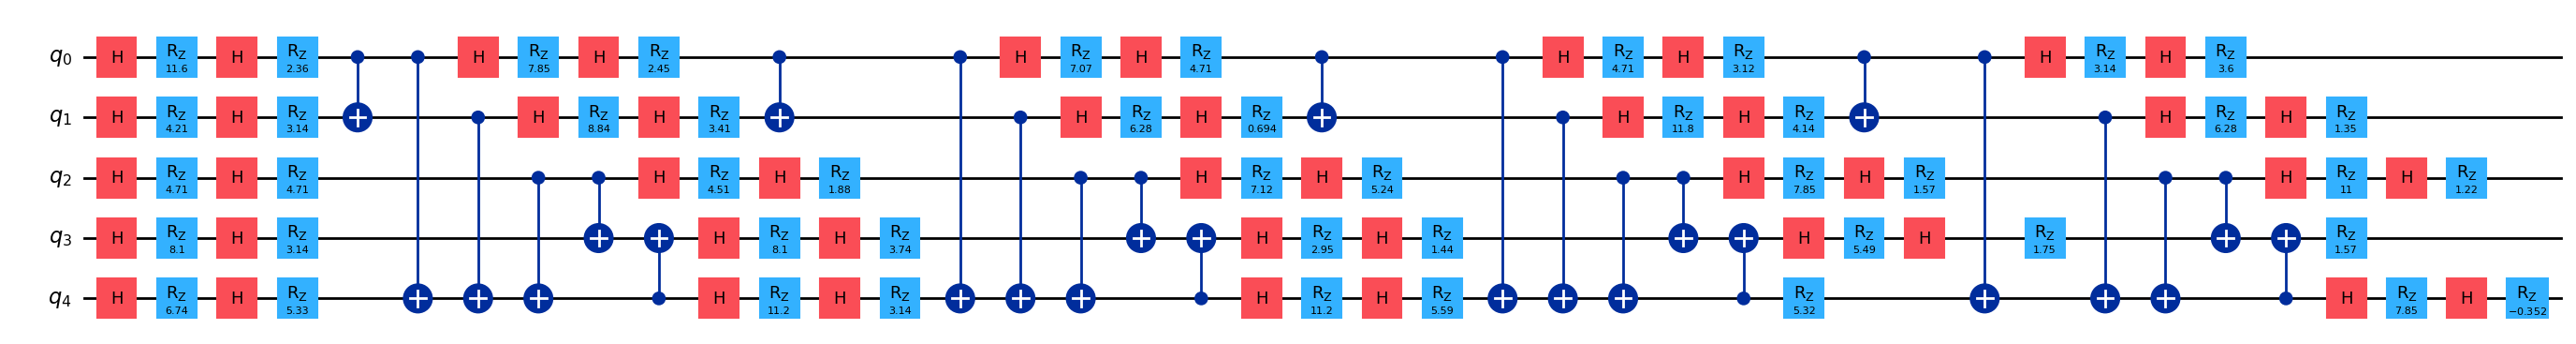

In [15]:
print("Transpiled Final Circuit:\n")
transpiled_circuit.draw("mpl", fold=-1)

In [14]:
# transpiled circuit characteristics
print_qc_characteristics(transpiled_circuit)

Quantum circuit characteristics
  Depth: 39
  Number of qubits: 5
  Operations: {'rz': 48, 'h': 46, 'cx': 24}
  Number of multi-qubit Operations: 24


The transpiled circuit minimizes the final circuit by reducing the unnecessary and overlapping same gates. And, it produces the same outcome as the final circuit.